# ML results on Resampled Data

In this notebook, we put together our previous discussions to examine the impact of resampling techniques we discussed earlier to our results.

In [1]:
# utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import time
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

# not advisable, but we do it for a cleaner report
# warnings regarding non-convergence of some classifiers used are muted
import warnings 
warnings.filterwarnings("ignore")

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import NearestNeighbors

In [2]:
# resampling functions
def random_undersample(feature_frame, target_array, random_state=11):
    """Return data with undersampled minority class to balance the data"""
    
    dataset = feature_frame.copy()
    dataset['target'] = y
    minority_class = dataset['target'].value_counts().argmin()
    
    # number of samples to retain from majority class, minority class count
    n = int(dataset['target'].value_counts().min())
    
    # rows to retain from majority
    retain_rows = (dataset[dataset['target'] != minority_class]
                   .sample(n=n, random_state=random_state, replace=True))
    
    # minority class rows and sampled majority class rows
    dataset = dataset[dataset['target']==minority_class].append(retain_rows)
    
    X_resampled = dataset.drop(columns='target') 
    y_resampled = dataset['target']
    
    return X_resampled, y_resampled

def random_oversample(feature_frame, target_array, random_state=11):
    """Return data with oversampled minority class to balance the data"""
    
    dataset = feature_frame.copy()
    dataset['target'] = y
    minority_class = dataset['target'].value_counts().argmin()
    
    # number of samples to generate
    n = int(dataset['target'].value_counts().diff().abs().sum() )
    
    new_rows = (dataset[dataset['target']==minority_class]
                .sample(n=n, random_state=random_state, replace=True))
    
    dataset = dataset.append(new_rows)
    
    X_resampled = dataset.drop(columns='target') 
    y_resampled = dataset['target']
    
    return X_resampled, y_resampled

from sklearn.neighbors import NearestNeighbors
def smote(feature_frame, target_array, beta=1, n_neighbors=5, random_state=42):
    """Return resampled X, y data from SMOTE method"""
    
    # initialize random seed for reproducibility
    np.random.seed(random_state)
    
    feature_frame = feature_frame.reset_index(drop=True)
    target_array = target_array.reset_index(drop=True)

    m_l = target_array.value_counts().max()
    m_s = target_array.value_counts().min()

    # label of minority class
    minority_label = target_array.value_counts().argmin()

    # get index of minority samples
    minority_indices = list(target_array[(target_array==minority_label)].index)
    minority_frame = feature_frame.iloc[minority_indices]

    # get minority neighbors of minority samples, n_neighbors inlcudes self (hence '+1')
    neighbors = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(minority_frame)
    _, nbrs_indices = neighbors.kneighbors(minority_frame)

    # count number of samples to meet preferred class ratio
    new_samples_count = (beta * m_l) - m_s

    # generate random indices, random selection of reference samples
    index_list = np.random.randint(0, minority_frame.shape[0], 
                                   size=new_samples_count)

    synth_samples = []
    for ref_index in index_list:
        other_index = np.random.choice(nbrs_indices[ref_index, 1:])
        x = minority_frame.iloc[ref_index].to_numpy().reshape(1, -1)
        xz = minority_frame.iloc[other_index].to_numpy().reshape(1, -1)

        # generate synthetic data
        synth_sample = x + (xz - x) * np.random.uniform(0, 1)
        synth_samples.append(synth_sample[0])

    # transform new samples into a dataframe
    synth_df = pd.DataFrame(np.array(synth_samples), 
                            columns=feature_frame.columns)
    # target col, all from minority class
    synth_df['target'] = [minority_label for i in range(synth_df.shape[0])] 

    # prepare outputs
    dataset = feature_frame.reset_index(drop=True)
    dataset['target'] = target_array.reset_index(drop=True)
    dataset = dataset.append(synth_df)
    X_resampled = dataset.drop(columns='target')
    y_resampled = dataset['target']   
    return X_resampled, y_resampled

def adasyn(feature_frame, target_array, d_tresh, beta, n_neighbors, 
           random_state=11):
    """Return resampled X, y data from ADASYN method"""
    
    # initialize random seed for reproducibility
    np.random.seed(random_state)
    
    m_l = target_array.value_counts().max()
    m_s = target_array.value_counts().min()
    
    d =  m_s / m_l 
    
    # d_tresh is the maximum allowed class ratio before resampling triggers
    if not (d < d_tresh):
        return None
    
    # number of samples to add, controlled by beta
    G = (m_l - m_s) * beta

    # label of minority class
    minority_label = target_array.value_counts().argmin()
    
    # get neighbors of all samples, n_neighbors inlcudes self (hence '+1')
    neighbors = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(feature_frame)
    _, nbrs_indices = neighbors.kneighbors(feature_frame)

    target_array = target_array.reset_index(drop=True)
    minority_indices = list(target_array[(target_array==minority_label)].index)
    minority_nbrs = nbrs_indices[minority_indices, 1:]


    r_array = [] # array of ratios, (number of m_l / n_neighbors)
    for nbrs in minority_nbrs:

        # n_neighbors minus minority count
        delta = n_neighbors - (target_array[nbrs]==minority_label).sum()
        r = delta / n_neighbors
        r_array.append(r)

    # normalize r_array, r_density_dist sums to 1
    r_density_dist = r_array / np.sum(r_array)

    # count of synthetic samples to be generated per minority sample
    gs = np.round(np.array(r_density_dist) * G)

    synth_samples = []
    for index, minority_index in enumerate(minority_indices):
        # reshape the m_s sample of interest
        x = feature_frame.iloc[minority_index].to_numpy().reshape(1, -1)
        nbrs = minority_nbrs[index]

        x_nbr = [i for i in nbrs if i in minority_indices]

        if len(x_nbr):
            for i in range(int(gs[index])):
                # choose one random neighbor that is also m_s
                xz = (feature_frame.iloc[np.random.choice(x_nbr)]
                                    .to_numpy()
                                    .reshape(1, -1))

                synth_sample = x + (xz - x) * np.random.uniform(0, 1)
                synth_samples.append(synth_sample[0])

        # if no nbr from minority, skip generating synth samples
        else: 
            continue

    # transform new samples into a dataframe
    synth_df = pd.DataFrame(np.array(synth_samples), 
                            columns=feature_frame.columns)
    # target col, all from minority class
    synth_df['target'] = [minority_label for i in range(synth_df.shape[0])] 
    
    # prepare outputs
    dataset = feature_frame.reset_index(drop=True)
    dataset['target'] = target_array.reset_index(drop=True)
    dataset = dataset.append(synth_df)
    X_resampled = dataset.drop(columns='target')
    y_resampled = dataset['target']    
    
    return X_resampled, y_resampled

In [3]:
# other functions
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import cross_val_score

def get_confusion_matrix(y_true, y_pred, return_tuple=False):
    """Return confusion matrix from inputs of true and predicted values"""
    TP = ((y_pred == 1) & (y_true == 1)).sum()
    TN = ((y_pred == 0) & (y_true == 0)).sum()
    FP = ((y_pred == 1) & (y_true == 0)).sum()
    FN = ((y_pred == 0) & (y_true == 1)).sum()
    if return_tuple:
        return TN, FP, FN, TP
    return np.array([[TN, FP],
                     [FN, TP]])

def g_mean(y_true, y_pred):
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred, return_tuple=True)
    
    specificity = TN / (FP + TN)
    sensitivity = recall_score(y_true, y_pred)
    score = np.sqrt(sensitivity * specificity)
    return score

g_mean_scorer = make_scorer(g_mean)

**Note: Resampling codes that we will be implementing take in pd.DataFrame X inputs, and pd.Series y inputs**

## Prepare Data

In [4]:
df = pd.read_csv('covid_clinical.csv')
df.head(3)

,pid,var1,var2,var3,class
0,0,-0.294129,-1.770098,2.331246,0
1,1,0.492923,-0.528002,1.173842,0
2,2,0.430697,0.053801,0.322743,0


In [5]:
# split into trainval and holdout
target_name = 'class'
X, y = df.drop(columns=[target_name] + ['pid']), df[target_name]

(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                            random_state=11, test_size=0.25, 
                                           stratify=y)

## Resampled Results

In [6]:
models_dict = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegressor': LogisticRegression(),
    'LinearSVM': SVC(kernel='linear'),
    'RBFSVM': SVC(),
    'GaussianNB': GaussianNB(),
    'RandomForestClassifier': RandomForestClassifier(random_state=11),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=11),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=11)   
}


### RandomOversampling

In [7]:
# budget automl
skf = StratifiedKFold(n_splits=5)

res_oversampled = {}

# log start time
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    train_scores = []
    val_scores = []
    
    for train_index, val_index in skf.split(X_trainval, y_trainval):
        
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
        
        start_time = time.time() # for logging run times
        
        (X_train, 
         y_train) = random_oversample(X_train, y_train, random_state=11)
        
        # fit
        model.fit(X_train, y_train)
        
        # default metric: accuracy
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        
        train_score = g_mean(y_train, train_preds)
        val_score = g_mean(y_val, val_preds)
        
        end_time = time.time() # for logging run times
        
        train_scores.append(train_score)
        val_scores.append(val_score)
        
    res_oversampled[model_name] = {
        'ave_train_g_mean':np.mean(train_scores) * 100,
        'ave_val_g_mean':np.mean(val_scores) * 100,
        'run_time': end_time - start_time
    }
    
# log end time
total_end = time.time()

elapsed = total_end - total_start
print(f"Report Generated in {elapsed:.2f} seconds")
res_oversampled = pd.DataFrame(res_oversampled).T
display(res_oversampled)

100%|██████████| 8/8 [00:03<00:00,  2.25it/s]

Report Generated in 3.57 seconds


,ave_train_g_mean,ave_val_g_mean,run_time
KNeighborsClassifier,99.095645,83.954339,0.066311
LogisticRegressor,69.572057,67.397684,0.018216
LinearSVM,73.302915,70.647184,0.090185
RBFSVM,88.899018,84.569253,0.073379
GaussianNB,63.685822,60.014981,0.015155
RandomForestClassifier,100.000000,76.369499,0.248459
DecisionTreeClassifier,100.000000,79.891115,0.019430
GradientBoostingClassifier,99.939970,78.186549,0.169612


In [8]:
# budget automl
skf = StratifiedKFold(n_splits=5)

res_smote = {}

# log start time
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    train_scores = []
    val_scores = []
    
    for train_index, val_index in skf.split(X_trainval, y_trainval):
        
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
        
        start_time = time.time() # for logging run times
        
        (X_train, 
         y_train) = smote(X_train, y_train, beta=1, n_neighbors=5, random_state=11)
        
        
        # fit
        model.fit(X_train, y_train)
        
        # default metric: accuracy
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        
        train_score = g_mean(y_train, train_preds)
        val_score = g_mean(y_val, val_preds)
        
        end_time = time.time() # for logging run times
        
        train_scores.append(train_score)
        val_scores.append(val_score)
        
    res_smote[model_name] = {
        'ave_train_g_mean':np.mean(train_scores) * 100,
        'ave_val_g_mean':np.mean(val_scores) * 100,
        'run_time': end_time - start_time
    }
    
# log end time
total_end = time.time()

elapsed = total_end - total_start
print(f"Report Generated in {elapsed:.2f} seconds")
res_smote = pd.DataFrame(res_smote).T
display(res_smote)

100%|██████████| 8/8 [00:08<00:00,  1.11s/it]

Report Generated in 8.89 seconds


,ave_train_g_mean,ave_val_g_mean,run_time
KNeighborsClassifier,97.011823,83.941574,0.196051
LogisticRegressor,68.461587,65.167264,0.139901
LinearSVM,73.930963,70.647184,0.213455
RBFSVM,91.549270,83.540690,0.194270
GaussianNB,63.528719,57.200216,0.136667
RandomForestClassifier,100.000000,81.905046,0.410015
DecisionTreeClassifier,100.000000,81.967330,0.143744
GradientBoostingClassifier,98.557212,81.496223,0.330840


In [9]:
# budget automl
skf = StratifiedKFold(n_splits=5)

res_adasyn = {}

# log start time
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    train_scores = []
    val_scores = []
    
    for train_index, val_index in skf.split(X_trainval, y_trainval):
        
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
        
        start_time = time.time() # for logging run times
        
        (X_train, 
         y_train) = adasyn(X_train, y_train, d_tresh=0.3, beta=1, n_neighbors=5, 
                                  random_state=11)
        # fit
        model.fit(X_train, y_train)
        
        # default metric: accuracy
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        
        train_score = g_mean(y_train, train_preds)
        val_score = g_mean(y_val, val_preds)
        
        end_time = time.time() # for logging run times
        
        train_scores.append(train_score)
        val_scores.append(val_score)
        
    res_adasyn[model_name] = {
        'ave_train_g_mean':np.mean(train_scores) * 100,
        'ave_val_g_mean':np.mean(val_scores) * 100,
        'run_time': end_time - start_time
    }
    
# log end time
total_end = time.time()

elapsed = total_end - total_start
print(f"Report Generated in {elapsed:.2f} seconds")
res_adasyn = pd.DataFrame(res_adasyn).T
display(res_adasyn)

100%|██████████| 8/8 [00:05<00:00,  1.34it/s]

Report Generated in 5.98 seconds


,ave_train_g_mean,ave_val_g_mean,run_time
KNeighborsClassifier,98.802843,81.825314,0.125840
LogisticRegressor,46.373450,48.440948,0.090580
LinearSVM,40.905459,51.138415,0.127914
RBFSVM,93.624518,82.752410,0.137652
GaussianNB,57.586529,25.423451,0.088053
RandomForestClassifier,99.962085,83.549760,0.334938
DecisionTreeClassifier,100.000000,81.122905,0.086644
GradientBoostingClassifier,99.852034,78.588989,0.251080


In [10]:
# budget automl
skf = StratifiedKFold(n_splits=5)

res = {}

# log start time
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    train_scores = []
    val_scores = []
    
    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
        
        start_time = time.time() # for logging run times
        
        # fit
        model.fit(X_train, y_train)
        
        # default metric: accuracy
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        
        train_score = g_mean(y_train, train_preds)
        val_score = g_mean(y_val, val_preds)
        
        end_time = time.time() # for logging run times
        
        train_scores.append(train_score)
        val_scores.append(val_score)
        
    res[model_name] = {
        'ave_train_g_mean':np.mean(train_scores) * 100,
        'ave_val_g_mean':np.mean(val_scores) * 100,
        'run_time': end_time - start_time
    }
    
# log end time
total_end = time.time()

elapsed = total_end - total_start
print(f"Report Generated in {elapsed:.2f} seconds")
res = pd.DataFrame(res).T
display(res)

100%|██████████| 8/8 [00:02<00:00,  3.27it/s]

Report Generated in 2.45 seconds


,ave_train_g_mean,ave_val_g_mean,run_time
KNeighborsClassifier,81.518959,79.315652,0.051876
LogisticRegressor,27.237586,21.213203,0.015041
LinearSVM,44.709258,40.641294,0.016170
RBFSVM,76.073359,75.751713,0.017072
GaussianNB,22.439387,7.071068,0.010907
RandomForestClassifier,99.685020,65.385197,0.230441
DecisionTreeClassifier,100.000000,76.784078,0.011687
GradientBoostingClassifier,100.000000,66.644877,0.135352


In [11]:
combined_res = pd.DataFrame(index=models_dict.keys())
combined_res['NoResampling Val GMean'] = res['ave_val_g_mean']
combined_res['RandomOversampling Val GMean'] = res_oversampled['ave_val_g_mean']
combined_res['SMOTE Val GMean'] = res_smote['ave_val_g_mean']
combined_res['ADASYN Val GMean'] = res_adasyn['ave_val_g_mean']
combined_res

,NoResampling,RandomOversampling Val GMean,SMOTE Val GMean,ADASYN Val GMean
KNeighborsClassifier,79.315652,83.954339,83.941574,81.825314
LogisticRegressor,21.213203,67.397684,65.167264,48.440948
LinearSVM,40.641294,70.647184,70.647184,51.138415
RBFSVM,75.751713,84.569253,83.540690,82.752410
GaussianNB,7.071068,60.014981,57.200216,25.423451
RandomForestClassifier,65.385197,76.369499,81.905046,83.549760
DecisionTreeClassifier,76.784078,79.891115,81.967330,81.122905
GradientBoostingClassifier,66.644877,78.186549,81.496223,78.588989


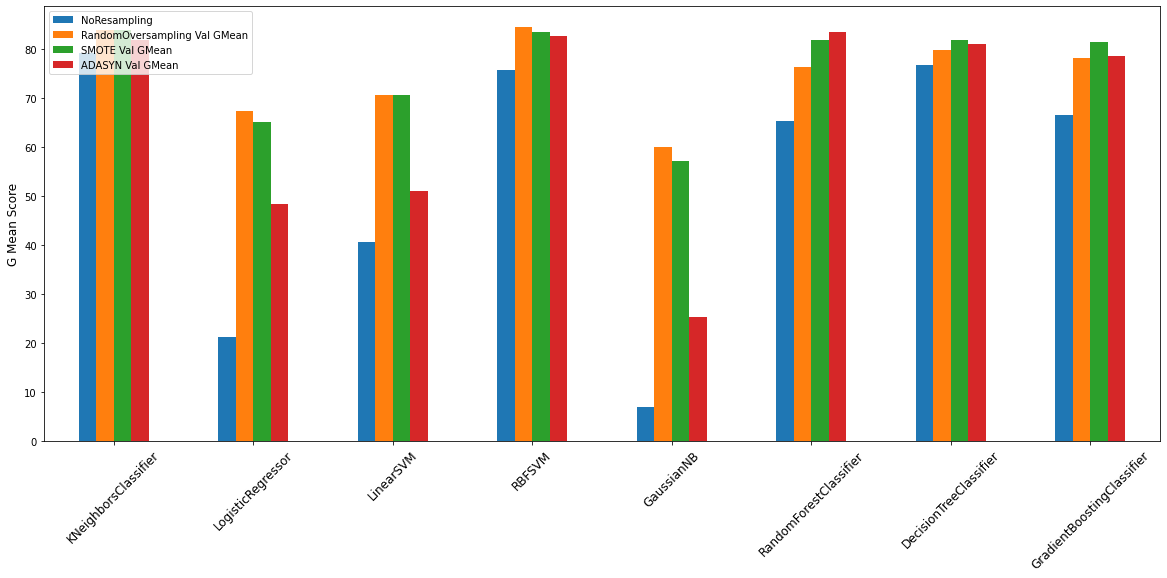

In [12]:
_, ax = plt.subplots(figsize=(20, 8))
combined_res.plot.bar(ax=ax)
ax.set_ylabel('G Mean Score', fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.show()

## Exercise 2: per LT

In this exercise, we will be working with the [Pima Indians Diabetes Dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database). The task is to perform the folllowing:

1. Discuss the objective (predicting diabetes outcomes) and agree on a suitable metric for this problem.
2. Compare the improvement in average validation accuracy (No Resampling, with Random Oversampling, SMOTE, and ADASYN), you may also try Random Undersampling.

In [14]:
df = pd.read_csv('diabetes.csv')
target = 'Outcome'

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
# insert code here